# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project 2: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **

Classification. B/z the target output is binary. Specifically, the outcome of the algorithm for a specific sample point is: either *yes* this student need early intervention; or *no* this student does not need early intervention. Convert to mathmatical language, the outcome can be encoded as 0 and 1.

The outcome of regression problem is usually continuous outputs, such as predicting housing prices, the numerical quantities (how many) of inventory goods, etc. 

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [2]:
# TODO: Calculate number of students
n_students = len(student_data)

# TODO: Calculate number of features
n_features = student_data.shape[1] - 1 

# TODO: Calculate passing students
n_passed = (student_data['passed']=='yes').sum()

# TODO: Calculate failing students
n_failed = (student_data['passed']=='no').sum()

# TODO: Calculate graduation rate
grad_rate = float(n_passed)/n_students * 100 # in percentage

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


**Imbalanced Class** - Notes taken from reviewer's feedbacks

Noticing that the labels are imbalanced - [tatics for handling imbalanced dataset](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)

Investigating f1 score if a super-naive model predict every sample point to be "passed" as benchmark...

In [3]:
# Reviewer's code feedback as reference
from sklearn.metrics import f1_score
print "\nF1 score for all 'yes' on students: {:.4f}".format(f1_score(y_true = ['yes']*n_passed + ['no']*n_failed, 
                                                                     y_pred = ['yes']*n_students, 
                                                                     pos_label='yes', average='binary'))


F1 score for all 'yes' on students: 0.8030


In [4]:
# Own code
y_true = student_data["passed"].replace("yes",1).replace("no",0)
y_pred = pd.Series([1]*len(y_true))
print "f1 score on the whole dataset if simply predicting every student passed:", f1_score(y_true, y_pred)

f1 score on the whole dataset if simply predicting every student passed: 0.80303030303


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [5]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [6]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

*Feedback from reviewer*
- Note that the label ratios are **imbalanced**, use *stratify* parameter in train_test_split to preserve the imbalanced percentage of samples for each class in train set and test set

In [7]:
# TODO: Import any additional functionality you may need here
from sklearn.cross_validation import train_test_split
# TODO: Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=num_test, stratify=y_all, random_state=897)


# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


In [8]:
print "Grad rate of the training set: {:.2f}%".format(100 * (y_train == 'yes').mean())
print "Grad rate of the testing set: {:.2f}%".format(100 * (y_test == 'yes').mean())

Grad rate of the training set: 67.00%
Grad rate of the testing set: 67.37%


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. What are the general applications of each model? What are their strengths and weaknesses? Given what you know about the data, why did you choose these models to be applied?*

**Answer: **

Our problem is a supervised binary classification problem. Support Vector Machine, Naive Bayes Classifier and K Nearest Neighbors are common models for solving this type of problems.

* **Support Vector Machines (SVM)**
    - Support Vector Machines(SVMs) with the aid of kernel methods solves supervised classification problems by finding the decision boundary which maximizes the margin. The simplest SVM is desinged to separate linearly separable binary classes. By introducing kernel methods, it allows to project linearly non-separable data into a hyperplane (transform data so that it is linearly separable) and then apply SVM to find the desired deicision boundary.
    - **General Application Examples**: SVM is widely used in imagine classification, such as faces classification. It has been used in hand-written digits classification (post service zip code recognition). It is also used in bioinformatics, such as classifying proteins.
    - **Strengths**:
        - In practice often it works well and produces good results in complicated domains with a clear margin separation.
        - It is somewhat robust to outliers.
        - SVMs with kernel tricks are powerful and can be used to address some non-linearly separable classes problems
        - The idea of "maximum margin" behind SVMs is easy to understand (even though mathmatically it may not be the case).
        - The numerical solution to the "maximize margin" problem can be translated into quadratic programming problem, which is a well understood and well studied linear algebra problem.
    - **Weaknesses**:
        - It's originally designed for binary class separation, although there are ways to reduce multi-class tasks to several binary class problems and then apply SVMs.
        - SVMs are computationally expensive: SVMs' time complexity is about O(n^3) where n is the size of the data, therefore it takes a long time to run with big data size.
        - It also does not perform well when there are a lot of noises in the data or when the data does not have a clear separable margin.
        - The parameters of the fitted model are difficult to intepret.
    - **Reasons for choosing**: SVM is selected because it's robustness and it's power for being able to model both linear and non-linear (with the aid of kernels) relations. In addition, given that our dataset is relatively small, time cost of training a SVM model would not be a constrain.


* **Naive Bayes Classifier (NB)**
    - Naive Bayes Classifier is a type of simple probabilistic classifiers. It applies Bayes' Theorem at heart to compute the probability of a sample point being a certain class given their features, then classify the sample point into the class with highest computed probability.
    - **General Application Examples**: It is widely used in natural language processing region, such as detecting spam emails based on the frequencies of words in the emails; and classifying the categories of a pieceo of article based on its content/words frequency. It is also used in disease detection.
    - **Strengths**:
        - Easy to interpret and easy to implement
        - It can deal with high input feature dimensions
        - It's computational efficient
        - Empirically it works well with natural langauge processing problems
        - It connects inference with classification
        - Performs well in small training sizes, no need to worry about hyper-parameter optimization.
    - **Weaknesses**:
        - The model assumes that different attributes are independent, which often are not the case in reality. Although in practices, a lot of times when attributes are not independent, the models still produce good result if the dependencies between attributes distribute evenly or cancels out ([a reference disscussion](http://stats.stackexchange.com/questions/23490/why-do-naive-bayesian-classifiers-perform-so-well)). However sometimes Naive Bayes Classifier might not work well due to the violation of this assumption.
        - It might not perform well if the samples/data used to train the model are not a representative drawn of the population. For instance, when a value of an attribute has never been seen to be associated with a label in the training set, the probability for this combination could be estimated to zero.
    - **Reasons for choosing**: It is easy to interpret and understand the fitted model. Also given the limited data sizes (300 data points in training set) and relatively large number of attributes (48 features), Naive Bayes classifier (high bias classifier) tends to perform well emprically.


* **K Nearest Neighbors (KNN) Classifier**
    - K Nearest Neighbors (KNN) Classifier is an instance based non-parametric classifier. It uses a defined similarity measuring metric, and then classifies the unseen data point by finding the K similariest sample points in the training set and *consulting* their labels. Commonly, the weights of the K similariest sample points can be set to be uniform or weighted by distance.
    - **General Application Examples**: In practice, KNN classifier is sometimes used in outlier detection, query trade classification, etc.
    - **Strengthes**:
        - Regarded as *lazy* classifier, it is very cheap and fast to train the model
        - The algorithm is simple and easy to implement, understand and intepret
        - Empirically it works well and is robust to noisy large dataset.
        - No need to retrain the model if there are newly collected data.
    - **Weakness**:
        - As a non-parametric classifier, it requires a lot of space to store all the training data.
        - Since making prediction requires to compute the similarities bewteen new data point and every sample point in the training set, the training time can be long if the data set is large
        - Need to determine K and distance metric, which may seem unclear and need a lot of experiments
        - It regards every attribute equally important, although it can be solved by applying different weights on different attributes. 
    - **Reasons for choosing**: KNN model is picked because it's every easy to understand and interpret. It's efficient to train. In addition, KNN model is adaptive in the sense that if in the future there are more data collected, there is no need to retrain the model to make new predictions. It would *self-adjust* to the growing of training set and make predictions based on that.

### A Review on Neural Network
* **Neural Network Classifiers**
    - Neural Network Classifiers are computational networks built up using (single layer or multilayer) perceptrons to solve supervised classification problems. A perceptron is a linear classifier used to solve supervised binary classification problems. It works by finding the appropriate weights for input attributes, and then compare the sum of weighted attributes with respect to a given threshold which could separate two different classes. Gradient descent and/or delta rule are often used to compute the *appropriate* weights for producing a good classifier. When multilayer perceptrons are desired, commonly backpropagation algorithm is used to train the model.
    - Strengths:
        - Neural network have relatively low restriction biases, which gives it power to represent different and complex functions (linear or non-linear). 
        - When the model structure, learning algorithms, and model parameters are choosen appropriately, the fitted model could be very robust and perform very well.
    - Weaknesses:
        - It is difficult to intepret the parameters/weights of the fitted model
        - It behaves like "black box" system, it is hard to intepret the relationship between the inputs and the outputs from a fitted model
        - It requires a lot of resources to train and tune a neural network model
    - Extra resources - notes taken from reviewer's feedbacks
        - sklearn provides [single layer preceptron in version 0.17](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html)
        - [Kera - a deep learning library](https://keras.io/) and its [tutorial](http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/)

### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [9]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)
    

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [19]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# TODO: Initialize the three models
clf_svc = SVC(random_state=672)
clf_gnb = GaussianNB()
clf_knn = KNeighborsClassifier()

# TODO: Set up the training set sizes
X_train_100 = X_train.iloc[:100]
y_train_100 = y_train.iloc[:100]

X_train_200 = X_train.iloc[:200]
y_train_200 = y_train.iloc[:200]

X_train_300 = X_train.iloc[:]
y_train_300 = y_train.iloc[:]

# TODO: Execute the 'train_predict' function for each classifier and each training set size
X_train_pre, y_train_pre = "X_train_", "y_train_"
sizes = ["100", "200", "300"]
clf_pre = "clf_"
clf_ids = ['svc','gnb','knn']
for cid in clf_ids:
    print "=============== ",cid," ================="
    clf_name = clf_pre+cid
    for s in sizes:
        print "------------------------------"
        X_train_name = X_train_pre + s
        y_train_name = y_train_pre + s
        train_predict(eval(clf_name), eval(X_train_name), eval(y_train_name), X_test, y_test)

#train_predict(clf_A, X_train, y_train, X_test, y_test)

===============  svc  =================
------------------------------
Training a SVC using a training set size of 100. . .
Trained model in 0.0055 seconds
Made predictions in 0.0027 seconds.
F1 score for training set: 0.8806.
Made predictions in 0.0008 seconds.
F1 score for test set: 0.8219.
------------------------------
Training a SVC using a training set size of 200. . .
Trained model in 0.0031 seconds
Made predictions in 0.0021 seconds.
F1 score for training set: 0.8758.
Made predictions in 0.0022 seconds.
F1 score for test set: 0.8079.
------------------------------
Training a SVC using a training set size of 300. . .
Trained model in 0.0071 seconds
Made predictions in 0.0046 seconds.
F1 score for training set: 0.8590.
Made predictions in 0.0015 seconds.
F1 score for test set: 0.8456.
===============  gnb  =================
------------------------------
Training a GaussianNB using a training set size of 100. . .
Trained model in 0.0006 seconds
Made predictions in 0.0002 seconds.

### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

** Classifer 1 - Support Vector Machine**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0055           |        0.0008          |     0.8806       |     0.8219      |
| 200               |        0.0031           |        0.0022          |     0.8758       |     0.8079      |
| 300               |        0.0071           |        0.0015          |     0.8590       |     0.8456      |

** Classifer 2 - Gaussian Naive Bayes**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0006           |        0.0002          |      0.7667      |     0.7167      |
| 200               |        0.0007           |        0.0002          |      0.8132      |     0.8372      |
| 300               |        0.0007           |        0.0002          |      0.8077      |     0.7752      |

** Classifer 3 - K Nearest Neighbors**  

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :---------------------: | :--------------------: | :--------------: | :-------------: |
| 100               |        0.0005           |        0.0016          |      0.8397      |      0.7612     |
| 200               |        0.0006           |        0.0016          |      0.8772      |      0.7801     |
| 300               |        0.0008           |        0.0020          |      0.8423      |      0.8000     |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Chosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

In [56]:
# performance analysis code incorporating feedbacks provided by reviewer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def performance_analysis(clfs):
    for clf in clfs:
        print '\nReport for {}:\n'.format(clf.__class__.__name__)
        print classification_report(y_test, clf.predict(X_test))
        print '-'*42
        cm = confusion_matrix(y_test, clf.predict(X_test))
        print 'Confusion Matrix for {}:\n'.format(clf.__class__.__name__)
        print "\t","pred no", "|", "pred yes"
        print "obs no\t", cm[0,0],"\t|\t", cm[0,1]
        print "obs yes\t", cm[1,0],"\t|\t", cm[1,1]
        print '='*64
    return
performance_analysis([clf_svc, clf_gnb, clf_knn])


Report for SVC:

             precision    recall  f1-score   support

         no       0.90      0.29      0.44        31
        yes       0.74      0.98      0.85        64

avg / total       0.79      0.76      0.71        95

------------------------------------------
Confusion Matrix for SVC:

	pred no | pred yes
obs no	9 	|	22
obs yes	1 	|	63

Report for GaussianNB:

             precision    recall  f1-score   support

         no       0.53      0.52      0.52        31
        yes       0.77      0.78      0.78        64

avg / total       0.69      0.69      0.69        95

------------------------------------------
Confusion Matrix for GaussianNB:

	pred no | pred yes
obs no	16 	|	15
obs yes	14 	|	50

Report for KNeighborsClassifier:

             precision    recall  f1-score   support

         no       0.58      0.45      0.51        31
        yes       0.76      0.84      0.80        64

avg / total       0.70      0.72      0.71        95

--------------------------

**Answer: **

- Model Performance Analysis 
    - with **classification report and confusion matrix** - tables printed in the section above
        - **SVM**: SVM yields the best precision, recall and f1 score on average. However it has a particularly low recall rate in the "did not pass"/"no" category (classification report). In the confusion matrix, SVM correctly classifies 72 students (true negative: 9 and true positive: 63). However it falsely classifies 22 failed students into the passed category. This indicates that although SVM model appears performing the best on average, it often mistakes students who are observed to be unable to graduate as students being able to pass. 
        - **GNB**: The average precision, recall and f1 score of GNB model are the lowest among three models. However its performances on the "no" and "yes" categories are very steady and stable (classification report). And it makes the least false negative mistakes (15 failed students are classified as "yes" as shown in the confusion matrix). Moreover, it successfully identifies the most true negative cases (16 students with true "no" labels are predicted with "no" labels.)
        - **KNN**: KNN yields pretty good precision, recall and f1 score on average. It has a lower recall rate on the "no"/"did not pass" category and a higher recall rate on the "yes"/"passed" category than **GNB** model (classification report). This suggests, KNN model does a slightly poorer job in detecting students who are going to fail/unable to graduate (17 false negative cases in confusion matrix) than **GNB** model.
    - with **increasing training sizes** - figures shown in the next section
        - **SVM**: The training f1 scores decrease with the increasing of training sizes, while the testing f1 scores increase with the increasing training sizes. This suggests that the SVM model's variances are decreasing when more training data is used, and it gets generalized better to unseen data.
        - **GNB**: The training f1 score boosts up when the training size increases from 100 data points to 200, then it remains roughly the same when the training size further increases. The testing f1 scores first increase then decrease with the increasing training size. The gap between the blue line (train) and orange line (test) increases slightly with the increasing training size. The f1 score variation suggests that the performance of the trained Gaussian Naive Bayes is not very stable. 
        - **KNN**: The training f1 scores produced by using 3 different training sizes fluctuate between 0.85 and 0.90; whereas the testing f1 scores demonstrate a steady increasing trend. The distance between the training score line and the testing score line decreases gradually. This implies that the fitted model variances decrease with the increasing training sizes, and it generalizes better to unseen data when the training data size is bigger.
- Model Efficiency Analysis
    - **SVM**: It is relatively slow to train a support vector machine model, and the training time increases significantly with the size of the training data. The prediction time cost is moderate among the three choosen models.
    - **GNB**: It is the fastest to train and make prediction using Gaussian Naive Bayes.
    - **KNN**: It is very fast to train the model, however it's relatively slow to make predictions using K Nearest Neighbors.
- Summary
    - Even though **SVM** seems to yeild the best f1 score, it makes the most mistakes in identifying students who may fail to graduate. On the contrast, **GNB** appears to produce the worst f1 score among 3 models, it performs well in detecting students who may fail to graduate. In addition, **SVM** model takes the longest to train, whereas **GNB** model is time cost efficient in terms of training and making perdictions. **KNN** yields moderate performances on all three evaluation metrics (the average precision, average recall and average f1 score). It is the fastest model to train, however more expensive to make predictions (still really fast given the our data size). Given the purpose of this project is to identify students who might fail to graudate an early intervention, **GNB** and **KNN** are the **two best models**. *However, since Gaussian Naive Bayes has no hyper-parameters, **KNN** model is choosen and the model tuning in next section is performed upon KNN model.*

In [10]:
svm_train = [0.8806, 0.8758, 0.8590]
svm_test  = [0.8219, 0.8079, 0.8456]
gnb_train = [0.7667, 0.8132, 0.8077]
gnb_test  = [0.7520, 0.8372, 0.7752]
knn_train = [0.8397, 0.8772, 0.8423]
knn_test  = [0.7612, 0.7801, 0.8000]

f1_scores_df = pd.DataFrame({'size' : [100,200,300]*2,    'label': ['train']*3+['test']*3,
                             'Support Vector Machine'  : svm_train+svm_test,
                             'Gaussian Naive Bayes'    : gnb_train+gnb_test,
                             'K Nearest Neighbors'     : knn_train+knn_test})

In [11]:
f1_scores_long = pd.melt(f1_scores_df, id_vars=['size','label'])
f1_scores_long.head()

,size,label,variable,value
0,100,train,Gaussian Naive Bayes,0.7667
1,200,train,Gaussian Naive Bayes,0.8132
2,300,train,Gaussian Naive Bayes,0.8077
3,100,test,Gaussian Naive Bayes,0.7520
4,200,test,Gaussian Naive Bayes,0.8372


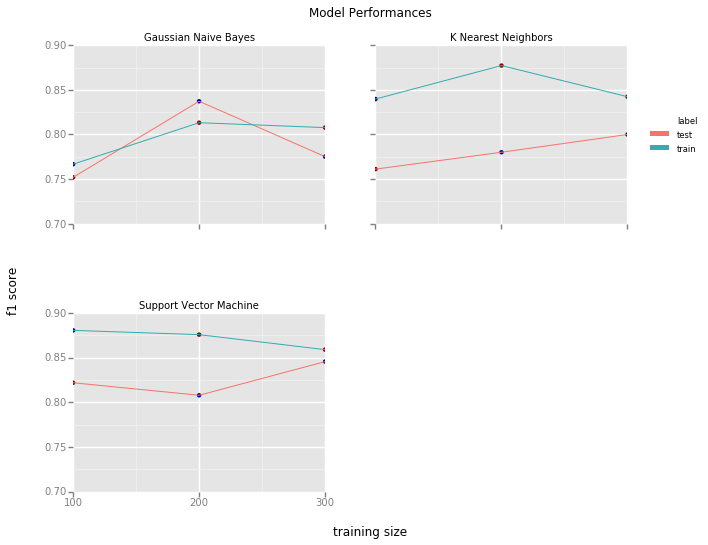

<ggplot: (284158333)>

In [13]:
%matplotlib inline
from ggplot import ggplot, aes, geom_line, facet_wrap, geom_point, xlab, ylab, ggtitle
from ggplot import scale_x_continuous, scale_y_continuous
p = ggplot(f1_scores_long, aes(x='size',y='value',color='label')) + geom_point() + geom_line() \
    + facet_wrap('variable')\
    + xlab('training size') + ylab('f1 score') + ggtitle('Model Performances') \
    + scale_x_continuous(limits=[100,300],breaks=[100,200,300]) \
    + scale_y_continuous(limits=[0.7, 0.9])
p

### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. For example if you've chosen to use a decision tree or a support vector machine, how does the model go about making a prediction?*

**Answer: **

As a lazy learner, the **K Nearest Neighbors (KNN)** classification model almost does nothing but remembers all the data in the model building phase. Most of the heavy lifting happens when we give the KNN model new data and ask it to classify the new data. 

Before we ask KNN model to make a prediction/classify the new data, the KNN model would ask us two important questions: 1) in what sense are two samples accounted as similar - a measure of distance; 2) how big do we want the *committee board/neighborhood* to be - the size of the *committee board/neighborhood* is also reflected in this algorithm's name, denoted by K. Specifically in our case, for instance, we may/could decide and tell the KNN model that if two students' *studytime* are the same value, then the distance between these two students is 0; and if two students' *studytime* are different, use the absolute value of two students' *studytime* difference as the distance measurement of these two students. And we may/could tell the KNN model that we think K=15 is the proper size for the *committee board/neighborhood*.

Once the model is being told about how to measure the distance between two sample points and the size of the *committee board/neighborhood*, when we ask the model to classify new data, the model will look at both the new data and the old data, and then calculate the distance between the new data and each old data which it remembers. Then the KNN model finds the 15 (or K in the general cases) closest data points in memory to the new data point to form the *committee board/neighborhood*. Then it asks the 15 *committee memebers/closest neighbors* to vote on what label should the new data point be. If the majority of the *committee memebers/cloest neighbors* have a label of "passed"/"yes", the model will then classify the new data as *passed*/"yes"; if the majority of the *committee memebers/cloest neighbors* have a label of *not passed*/*no*, it will also classify the new data as *not passed*/*no*.

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.gridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [72]:
# TODO: Import 'GridSearchCV' and 'make_scorer'
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
# TODO: Create the parameters list you wish to tune
parameters = {'n_neighbors' : [3, 5, 7, 10, 15, 20],
              'weights'    : ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree','brute'],
              'leaf_size' : [10, 20, 30, 40, 50, 60],
              'metric' : ['euclidean', 'minkowski', 'chebyshev', 'manhattan']}

# TODO: Initialize the classifier
clf = KNeighborsClassifier()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj = GridSearchCV(estimator=clf, param_grid=parameters,scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj = grid_obj.fit(X_train, y_train)

# Get the estimator
clf = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf, X_train, y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf, X_test, y_test))

Made predictions in 0.0045 seconds.
Tuned model has a training F1 score of 0.8118.
Made predictions in 0.0019 seconds.
Tuned model has a testing F1 score of 0.8000.


In [64]:
print "Paramteres for tuned model: \n", grid_obj.best_params_
#print grid_obj.grid_scores_

Paramteres for tuned model: 
{'n_neighbors': 15, 'metric': 'chebyshev', 'weights': 'uniform', 'leaf_size': 20, 'algorithm': 'auto'}


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

**Answer: **

The final model's f1 score is **0.8118** for the training set, and **0.8000** for the testing set. The tuned model's f1 score for training set is slightly lower than the untuned model, and the f1 score performance on the **testing set** is approximately as well as the untuned model.

**A little dive in performance analysis and disscussion of the tuned model:**

Even thought the final tuned model achieved similar f1 score as compared to the untuned/default parameter setting, it makes more false negative (26 samples observed with "no" labels were classified as "yes") mistakes than untuned KNN model. Since GridSearchCV uses 3-fold cross validation by default, the tuned model may still be more *trust-worthy* than the untuned KNN model. However, if **detecting students who may potentially fail to graduate** is the highest priority of the student_intervention model, then maybe **Gaussian Naive Bayes** model is the best candidate to do the job.

In [71]:
print '+'*21,'Tuned KNN Model','+'*21
performance_analysis([clf])
print '+'*21,'unTuned KNN and GNB',"+"*21
performance_analysis([clf_knn, clf_gnb])

+++++++++++++++++++++ Tuned KNN Model +++++++++++++++++++++

Report for KNeighborsClassifier:

             precision    recall  f1-score   support

         no       0.56      0.16      0.25        31
        yes       0.70      0.94      0.80        64

avg / total       0.65      0.68      0.62        95

------------------------------------------
Confusion Matrix for KNeighborsClassifier:

	pred no | pred yes
obs no	5 	|	26
obs yes	4 	|	60
+++++++++++++++++++++ unTuned KNN and GNB +++++++++++++++++++++

Report for KNeighborsClassifier:

             precision    recall  f1-score   support

         no       0.58      0.45      0.51        31
        yes       0.76      0.84      0.80        64

avg / total       0.70      0.72      0.71        95

------------------------------------------
Confusion Matrix for KNeighborsClassifier:

	pred no | pred yes
obs no	14 	|	17
obs yes	10 	|	54

Report for GaussianNB:

             precision    recall  f1-score   support

         no       0

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### Useful information and readings suggested by reviewer

 - [Feature scaling](http://sebastianraschka.com/faq/docs/when-to-standardize.html) can often have a big impact on the performance of machine learning algorithms.
 - Reading material on [scaling and normalizing](http://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/)
 - A blog on ideas and code snippets on [visualizing the results of a grid search](http://blog.districtdatalabs.com/visual-diagnostics-for-more-informed-machine-learning-part-3)
 - [Adaptive Boosting in Layman Language](https://www.quora.com/What-is-AdaBoost)
 - Interesting blogs/readings regarding to KNN
     - [Top 10 Data Mining Algorithms](https://rayli.net/blog/data/top-10-data-mining-algorithms-in-plain-english#8_kNN)
     - [Intro to KNN Classification and Clustering](http://www.analyticsvidhya.com/blog/2014/10/introduction-k-neighbours-algorithm-clustering/)
     - [Statistics - KNN](http://www.statsoft.com/textbook/k-nearest-neighbors)

**Experiments on Feature Normalizing and Scaling**

In [78]:
from sklearn.preprocessing import Normalizer

normer = Normalizer()
X_train_transform = normer.fit_transform(X_train)
X_test_transform = normer.transform(X_test)
parameters = {'n_neighbors' : [3, 5, 7, 10, 15, 20],
              'weights'    : ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree','brute'],
              'leaf_size' : [10, 20, 30, 40, 50, 60],
              'metric' : ['euclidean', 'minkowski', 'chebyshev', 'manhattan']}

# TODO: Initialize the classifier
clf_transform = KNeighborsClassifier()

# TODO: Make an f1 scoring function using 'make_scorer' 
f1_scorer = make_scorer(f1_score, pos_label='yes')

# TODO: Perform grid search on the classifier using the f1_scorer as the scoring method
grid_obj_transform = GridSearchCV(estimator=clf_transform, param_grid=parameters,scoring=f1_scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_obj_transform = grid_obj_transform.fit(X_train_transform, y_train)

# Get the estimator
clf_transform = grid_obj.best_estimator_

# Report the final F1 score for training and testing after parameter tuning
print "Tuned model has a training F1 score of {:.4f}.".format(predict_labels(clf_transform,X_train_transform,y_train))
print "Tuned model has a testing F1 score of {:.4f}.".format(predict_labels(clf_transform,X_test_transform,y_test))
print "Paramteres for tuned model: \n", grid_obj_transform.best_params_

Made predictions in 0.0047 seconds.
Tuned model has a training F1 score of 0.8024.
Made predictions in 0.0017 seconds.
Tuned model has a testing F1 score of 0.8050.
Paramteres for tuned model: 
{'n_neighbors': 20, 'metric': 'chebyshev', 'weights': 'distance', 'leaf_size': 50, 'algorithm': 'auto'}


In [77]:
print '+'*21,'Tuned KNN Model','+'*21
performance_analysis([clf_transform])

+++++++++++++++++++++ Tuned KNN Model +++++++++++++++++++++

Report for KNeighborsClassifier:

             precision    recall  f1-score   support

         no       0.56      0.16      0.25        31
        yes       0.70      0.94      0.80        64

avg / total       0.65      0.68      0.62        95

------------------------------------------
Confusion Matrix for KNeighborsClassifier:

	pred no | pred yes
obs no	5 	|	26
obs yes	4 	|	60
